<span style="font-size: 30px;">EJERCICIO DE CLASIFICACIÓN BAYESIANA </span>

A partir del dataset de pesos y alturas, construir manualmente (sin usar sklearn) un Clasificador Bayesiano LDA. Para calcular los parámetros, utilizar las fórmulas compartidas en la notebook correspondiente.

<span style="font-size: 24px;">Preparación de los datos</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data_train=pd.read_csv('C:/Users/ACER/Documents/FACULTAD/Redes Neuronales/alturas-pesos-mils-train.csv')
data_test=pd.read_csv('C:/Users/ACER/Documents/FACULTAD/Redes Neuronales/alturas-pesos-mils-test.csv')

In [38]:
#Paso la infromación del .csv a vectores para que sea más fácil manipular la información
genero_train= data_train['Genero']
wh_train=data_train.iloc[:, 2:4].values

genero_test= data_test['Genero']
wh_test=data_test.iloc[:, 2:4].values

In [39]:
wh_train

array([[ 61.235, 162.402],
       [ 97.432, 181.908],
       [ 73.324, 172.459],
       ...,
       [ 75.461, 170.91 ],
       [ 65.461, 166.137],
       [ 80.323, 171.575]])

In [40]:
wh_test

array([[ 90.202, 177.68 ],
       [ 60.89 , 164.175],
       [ 67.629, 171.506],
       ...,
       [ 51.971, 154.277],
       [ 82.536, 172.26 ],
       [ 62.409, 166.244]])

<span style="font-size: 24px;">A. Clasificador manual</span>

In [6]:
#Calculo las priors: la probabilidad de que una persona sea hombre o mujer
total=len(genero_train)
cant_hombres=len(genero_train[genero_train=='Hombre'])
cant_mujeres=len(genero_train[genero_train=='Mujer'])
suma=cant_mujeres + cant_hombres #esto es útil para asegurarse de que no hay otro tipo de dato
print("TOTAL:", total, "\nMUJERES",  cant_mujeres, "\nHOMBRES:", cant_hombres, "\nSUMA:", suma)
prior_hombre=cant_hombres/total
prior_mujer=cant_mujeres/total
print("PRIOR HOMBRES:", prior_hombre, "\nPRIOR MUJERES:", prior_mujer)

TOTAL: 8000 
MUJERES 3998 
HOMBRES: 4002 
SUMA: 8000
PRIOR HOMBRES: 0.50025 
PRIOR MUJERES: 0.49975


\begin{equation}
  P(C_{i} | w, h) = \frac{P( w, h | C_{i})\times P(C_{i})}{P(w,h)}
\end{equation}

Veo que la altura va de 140 a 200cm, y los pesos de 20 a 140kg.

In [7]:
#Propiedades para los bines
minw=20
maxw=130
minh=135
maxh=225
cantidad_bines=100
ancho_bines_peso=(maxw-minw)/cantidad_bines
ancho_bines_altura=(maxh-minh)/cantidad_bines

OPCIÓN 1: diseñamos un primer clasificador que si llega a un dato que no se puede clasificar, no lo toma en consideración

In [97]:
#OPCIÓN 1 - Si llega a un dato que no se puede clasificar, no lo toma en consideración
def probabilidad_wh_A(wh_vector, genero):
  cont_wh=0
  cont_dado_genero=0
  if(genero=='Hombre'):
    cant_genero=cant_hombres
  else:
    cant_genero=cant_mujeres

  peso=wh_vector[0]
  altura=wh_vector[1]

  #identifico en qué bin está
  binW=int((peso-minw)/ancho_bines_peso)
  binH=int((altura-minh)/ancho_bines_altura)

  infW=minw+binW*ancho_bines_peso #límite inferior de peso del bin
  supW=minw+(binW+1)*ancho_bines_peso #límite superior de peso del bin
  infH=minh+binH*ancho_bines_altura #límite inferior de altura del bin
  supH=minh+(binH+1)*ancho_bines_altura #límite superior de altura del bin

  #cuento cuántas muestras hay en ese bin
  for i in range(total):
    if (infW<= wh_train[i, 0] <supW) and (infH<= wh_train[i,1] <supH):
      cont_wh+=1
      if (genero_train[i]==genero):
        cont_dado_genero+=1

  if cont_wh==0:
    clasificado=False
    proba=0
    likelihood=0
  else:
      clasificado=True
      proba=cont_wh/total
      likelihood=cont_dado_genero/cant_genero
  
  return proba, likelihood, clasificado

In [104]:
def clasificador_manual_A(wh_vector, genero_vector):
    cant_noClasificados=0
    prediccion=[] #en este vector guardo los resultados de la predicción

    #Recorre todos los elementos del array y los clasifica 
    for i in range(len(genero_vector)):
        #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
        proba_wh, likelihood_hombre,clasificado= probabilidad_wh_A(wh_vector[i], 'Hombre')

        if clasificado==True:
            #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
            hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
            if(hombre_dado_wh>0.5):
                prediccion.append(1) #de esta forma, HOMBRE=1 MUJER=0
            else:
                prediccion.append(0)
        if clasificado==False:
            cant_noClasificados+=1
            print("La muestra ", i, "no se pudo clasificar")
    
    print("\n\nHUBO ", cant_noClasificados, " ELEMENTOS QUE NO PUDIERON SER CLASIFICADOS")
    #una vez que termina, convierto la lista con las predicciones en array
    prediccion=np.array(prediccion)

    return prediccion

OPCIÓN 2: En este segundo clasificador, si hay un dato que no puede ser clasificado, se compara esa muestra con los bins de alrededor del bin que le corresponde. Se ampliará el área de comparación hasta que la muestra pueda ser clasificada.

In [43]:
def probabilidad_wh(wh_vector, genero, cont_no):
  cont_wh=0
  cont_dado_genero=0
  if(genero=='Hombre'):
    cant_genero=cant_hombres
  else:
    cant_genero=cant_mujeres

  peso=wh_vector[0]
  altura=wh_vector[1]
  #identifico en qué bin está
  binW=int((peso-minw)/ancho_bines_peso)
  binH=int((altura-minh)/ancho_bines_altura)

  infW=minw+binW*ancho_bines_peso #límite inferior de peso del bin
  supW=minw+(binW+1)*ancho_bines_peso #límite superior de peso del bin
  infH=minh+binH*ancho_bines_altura #límite inferior de altura del bin
  supH=minh+(binH+1)*ancho_bines_altura #límite superior de altura del bin

  #cuento cuántas muestras hay en ese bin
  for i in range(total):
    if (infW<= wh_train[i, 0] <supW) and (infH<= wh_train[i,1] <supH):
      cont_wh+=1
      if (genero_train[i]==genero):
        cont_dado_genero+=1
  print("\thay ", cont_wh,"elementos que van en el mismo bin\n\tHay", cont_dado_genero, genero,"en el mismo bin")


  if cont_wh==0:
    print("\tNO SE ENCONTRÓ OTRO EN EL MISMO BIN")
    cont_no+=1
    proba=0
    likelihood=0
  else:
      proba=cont_wh/total
      likelihood=cont_dado_genero/cant_genero

  """
  while (cont_wh==0):
    k=1
    print("\tAmpliamos el bin")
    #Si no encuentra ningún elemento para comparar dentro del mismo bin, se amplía un bin a la redonda
    infW=minw+(binW-k)*ancho_bines_peso #límite inferior de peso del bin
    supW=minw+(binW+1+k)*ancho_bines_peso #límite superior de peso del bin
    infH=minh+(binH-k)*ancho_bines_altura #límite inferior de altura del bin
    supH=minh+(binH+1+k)*ancho_bines_altura #límite superior de altura del bin

    for i in range(total):
      if (infW<= peso_train[i] <supW) and (infH<= altura_train[i] <supH):
        cont_wh+=1
        if (genero_train[i]==genero):
          cont_dado_genero+=1
    print("\t\tAhora hay ", cont_wh,"elementos que van en el mismo bin\n\t\tHay", cont_dado_genero, genero,"en el mismo bin")
    k+=1;
    if k==5:
      break
  """

  return proba, likelihood, cont_no

<span style="font-size: 20px;"> A.1. Imágenes de entrenamiento </span>

In [100]:
#con la primera opción
prediccion_manual_train_A=clasificador_manual_A(wh_train, genero_train)

Hubo  0  elementos que no puedieron ser clasificados


In [ ]:
prediccion_manual_train=np.zeros(len(data_train)) #en este vector guardo los resultados de la predicción
for i in range(len(data_train)):
  #print("Evalúo el elemento ",i, "---PESO=", peso_train[i], "---ALTURA=", altura_train[i])
  proba_wh, likelihood_hombre, cont_no= probabilidad_wh(wh_train[i], 'Hombre', cont_no)

  #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
  hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
  if(hombre_dado_wh>0.5):
    prediccion_manual_train[i]=1 #de esta forma, HOMBRE=1 MUJER=0

<span style="font-size: 20px;"> A. 2. Imágenes de testeo </span>

In [105]:
prediccion_manual_test_A=clasificador_manual_A(wh_test, genero_test)

La muestra  49 no se pudo clasificar
La muestra  123 no se pudo clasificar
La muestra  133 no se pudo clasificar
La muestra  256 no se pudo clasificar
La muestra  259 no se pudo clasificar
La muestra  369 no se pudo clasificar
La muestra  372 no se pudo clasificar
La muestra  375 no se pudo clasificar
La muestra  376 no se pudo clasificar
La muestra  383 no se pudo clasificar
La muestra  526 no se pudo clasificar
La muestra  534 no se pudo clasificar
La muestra  570 no se pudo clasificar
La muestra  582 no se pudo clasificar
La muestra  626 no se pudo clasificar
La muestra  635 no se pudo clasificar
La muestra  644 no se pudo clasificar
La muestra  710 no se pudo clasificar
La muestra  730 no se pudo clasificar
La muestra  746 no se pudo clasificar
La muestra  789 no se pudo clasificar
La muestra  792 no se pudo clasificar
La muestra  844 no se pudo clasificar
La muestra  849 no se pudo clasificar
La muestra  925 no se pudo clasificar
La muestra  1026 no se pudo clasificar
La muestra  

In [ ]:
prediccion_manual_test=np.zeros(len(data_test)) #en este vector guardo los resultados de la predicción
cont_no=0
for i in range(len(data_test)):
  print("Evalúo el elemento ",i, "---PESO=", peso_test[i], "---ALTURA=", altura_test[i])
  proba_wh, likelihood_hombre, cont_no = probabilidad_wh(wh_test[i], 'Hombre', cont_no)

  #Calculo, por medio del teorema de Bayes, la probabilidad de que sea hombre
  hombre_dado_wh= (likelihood_hombre * prior_hombre)/proba_wh
  if(hombre_dado_wh>0.5):
    prediccion_manual_test[i]=1 #de esta forma, HOMBRE=1 MUJER=0

  print("Hubo ", cont_no, "muestras que no pudieron ser clasificadas!!!")

In [ ]:
#Paso los valores reales a números
genero_train_binario=np.zeros(total)
for i in range(total):
  if(genero_train[i]=='Hombre'):
    genero_train_binario[i]=1

In [ ]:
genero_test_binario=np.zeros(len(genero_test))
for i in range(len(genero_test)):
  if(genero_test[i]=='Hombre'):
    genero_test_binario[i]=1

In [ ]:
etiquetas=['Hombre', 'Mujer']

<span style="font-size: 20px;"> A. 3. Métricas </span>

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

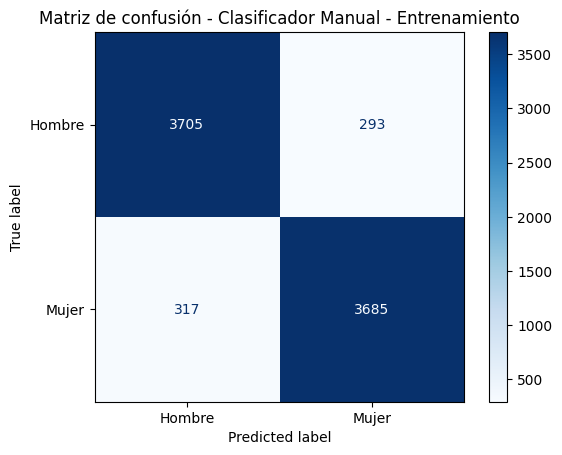

In [ ]:
cm_manual_train=confusion_matrix(genero_train_binario, prediccion_manual_train)
disp_manual_train = ConfusionMatrixDisplay(cm_manual_train, display_labels=etiquetas)
disp_manual_train.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión - Clasificador Manual - Entrenamiento')
plt.show()

<span style="font-size: 24px;"> B. Clasificador de SciKit-Learn </span>

In [ ]:
from sklearn.naive_bayes import GaussianNB

<span style="font-size: 20px;"> B. 1. Imágenes de entrenamiento </span>

In [ ]:
clf_sklearn = GaussianNB()
clf_sklearn.fit(wh_train, genero_train_binario)  # Entrenar el modelo
prediccion_sklearn_train = clf_sklearn.predict(wh_train)

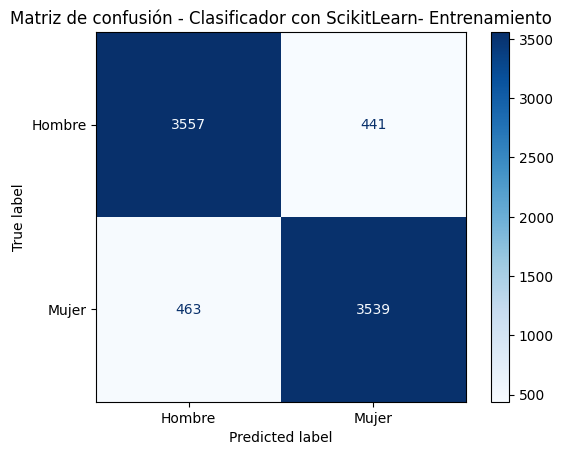

In [ ]:
cm_sklearn_train=confusion_matrix(genero_train_binario, prediccion_sklearn_train)
disp_sklearn_train = ConfusionMatrixDisplay(cm_sklearn_train, display_labels=etiquetas)
disp_sklearn_train.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión - Clasificador con ScikitLearn- Entrenamiento')
plt.show()

<span style="font-size: 20px;"> B. 2. Imágenes de testeo </span>

In [ ]:
prediccion_sklearn_test = clf_sklearn.predict(wh_test)

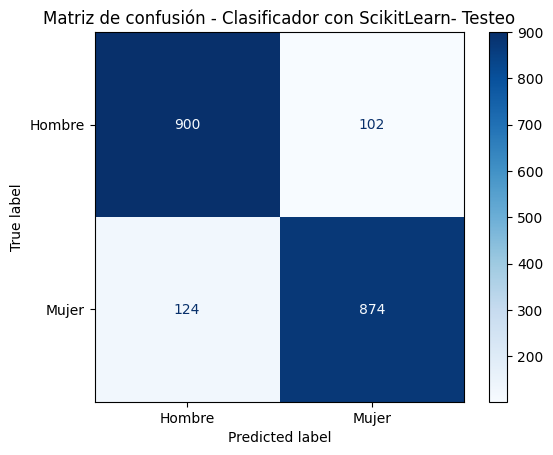

In [ ]:
cm_sklearn_test=confusion_matrix(genero_test_binario, prediccion_sklearn_test)
disp_sklearn_test = ConfusionMatrixDisplay(cm_sklearn_test, display_labels=etiquetas)
disp_sklearn_test.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión - Clasificador con ScikitLearn- Testeo')
plt.show()

<span style="font-size: 20px;"> B. 3. Métricas </span>

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_sklearn_train = accuracy_score(genero_train_binario, prediccion_sklearn_train )
accuracy_sklearn_test = accuracy_score(genero_test_binario, prediccion_sklearn_test)


In [ ]:
print("ACCURACY DEL MODELO ENTRENADO CON SCIKIT-LEARN")
print("\tConjunto de entrenamiento: ", accuracy_sklearn_train, "\n\tConjunto de testeo: ", accuracy_sklearn_test)

ACCURACY DEL MODELO ENTRENADO CON SCIKIT-LEARN
	Conjunto de entrenamiento:  0.887 
	Conjunto de testeo:  0.887


<span style="font-size: 24px;"> C. Clasificación con método de Expansión Cuadrática </span>

In [ ]:
#PREPARO EL VECTOR CON LOS DATOS
def expandir_datos(wh_vector):
    datos_extension=np.zeros([len(wh_vector), 5])
    for i in range(len(wh_vector)):
        peso=wh_train[i, 0]
        altura=wh_train[i, 1]
        datos_extension[i, 0]=peso
        datos_extension[i, 1]=peso**2
        datos_extension[i, 2]=altura
        datos_extension[i, 3]=altura**2
        datos_extension[i, 4]=peso*altura
    return datos_extension

In [ ]:
datos_expansion_train= expandir_datos(wh_train)
datos_expansion_test=expandir_datos(wh_test)

<span style="font-size: 20px;"> C. 1. Imágenes de entrenamiento </span>

In [ ]:
clf_sklearn.fit(datos_expansion_train, genero_train_binario)  # Entrenar el modelo
prediccion_expansion_train = clf_sklearn.predict(datos_expansion_train)

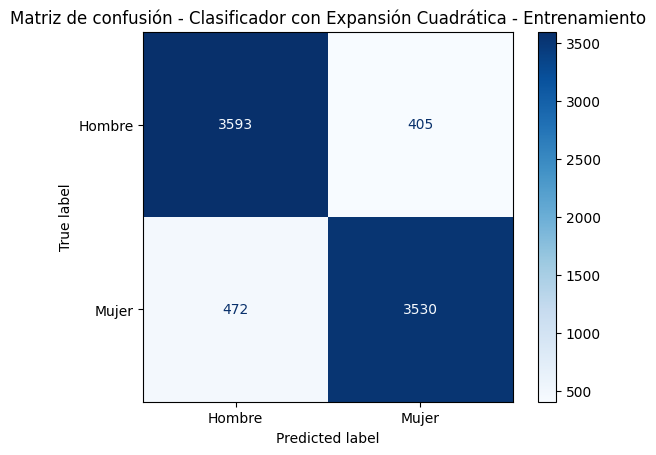

In [ ]:
cm_expansion_train=confusion_matrix(genero_train_binario, prediccion_expansion_train)
disp_expansion_train = ConfusionMatrixDisplay(cm_expansion_train, display_labels=etiquetas)
disp_expansion_train.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión - Clasificador con Expansión Cuadrática - Entrenamiento')
plt.show()

<span style="font-size: 20px;"> C. 2. Imágenes de testeo </span>

In [ ]:
prediccion_expansion_test = clf_sklearn.predict(datos_expansion_test)

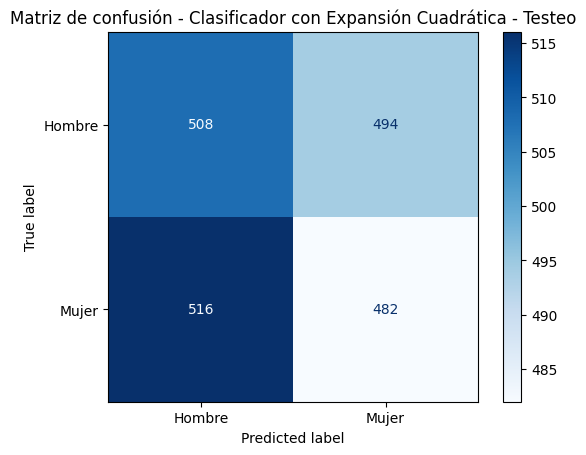

In [ ]:
cm_expansion_test=confusion_matrix(genero_test_binario, prediccion_expansion_test)
disp_expansion_test = ConfusionMatrixDisplay(cm_expansion_test, display_labels=etiquetas)
disp_expansion_test.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión - Clasificador con Expansión Cuadrática - Testeo')
plt.show()

<span style="font-size: 20px;"> C. 3. Métricas </span>

In [ ]:
accuracy_expansion_train = accuracy_score(genero_train_binario, prediccion_expansion_train )
accuracy_expansion_test = accuracy_score(genero_test_binario, prediccion_expansion_test)
print("ACCURACY DEL MODELO ENTRENADO CON DATOS EXPANDIDOS")
print("\tConjunto de entrenamiento: ", accuracy_expansion_train, "\n\tConjunto de testeo: ", accuracy_expansion_test)


ACCURACY DEL MODELO ENTRENADO CON DATOS EXPANDIDOS
	Conjunto de entrenamiento:  0.890375 
	Conjunto de testeo:  0.495
